The GraphConv model we created can now be applied used to search the set of commercially available compounds we just filtered.  
Applying the model will consist of a few steps.
1. Load the model from disc
2. Create a featurizer
3. Read an featurize the molecules that we will run through the model
4. Examine the scores for the predictions
5. Examine the chemical strucutres of the top predicted molecules
6. Cluster the selected molecules
7. Write the selected molecules from each cluster to a csv file

We will begin by importing the necessary libraries

In [20]:
import deepchem as dc
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
import seaborn as sns

We then read the model that we generated earlier from disc

In [3]:
model = dc.models.TensorGraph.load_from_dir("/home/pwalters/DATA/DEEPCHEM/mk01/model_dir")

/home/pwalters/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from /home/pwalters/DATA/DEEPCHEM/mk01/model_dir/model-290


In order to generated predictions from our model, we first need to featurize the molecules we plan to use to generate predictions.

In [4]:
featurizer = dc.feat.ConvMolFeaturizer()

In order to featurize the molecules, we need to transform our SMILES file into a csv.  The DeepChem featurizer also requires an activity column, so we will add one then write the file to csv. **Is there another way to do this?**

In [5]:
df = pd.read_csv("zinc.smi",sep=" ",header=None)

In [6]:
df.columns=["SMILES","Name"]

In [42]:
rows,cols = df.shape
df["Val"] = [0] * rows #just add add a dummy column to keep the featurizer happy

In [8]:
df.head()

,SMILES,Name,Val
0,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
1,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C@@H]1NC(C)=O,ZINC000000041101,0
2,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,0
3,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,0
4,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,0


In [9]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

We can the read this csv file with a loader and featurize the molecules we plan to predict. 

In [43]:
loader = dc.data.CSVLoader(tasks=['Val'], smiles_field="SMILES", featurizer=featurizer)

In [11]:
dataset = loader.featurize(infile_name, shard_size=8192)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from zinc_filtered.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 22.150 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 19.897 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 19.131 s
Loading shard 4 of size 8192.
Featurizing sample 0
Fe

The featurized molecules can be used to generate predcitions with the model.

In [12]:
pred = model.predict(dataset)

In [13]:
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])

A distribtion plot provides a nice overview of the distribution of scores.  We cna see that only a few molecules have scores >= 0.3.

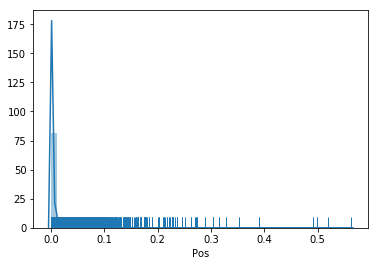

In [14]:
sns.distplot(pred_df.Pos,rug=True)

The dataframe with the scores can be joined to the dataframe with the SMILES.  This will give us the ability to view the top scoring molecules.

In [15]:
combo_df = df.join(pred_df,how="outer")

In [16]:
combo_df.sort_values("Pos",inplace=True,ascending=False)

Adding a molecule column to the dataframe enables us to look at the chemical strucutres of the hits.

In [17]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")

,SMILES,Name,Val,Neg,Pos,Mol
63669,O=C(NC[C@@H](CO)NC(=O)c1ccncn1)c1ccncn1,ZINC000681745616,0,0.438595,0.561404,
55121,Cn1cncc1C(=O)NC[C@@H](CO)NC(=O)c1cncn1C,ZINC000644062250,0,0.481628,0.518372,
38671,CN(C)c1nc(N)nc(C(=O)N[C@H](CO)c2ccnn2C)n1,ZINC000566403331,0,0.501487,0.498513,
38672,CN(C)c1nc(N)nc(C(=O)N[C@@H](CO)c2ccnn2C)n1,ZINC000566403338,0,0.501487,0.498513,
63530,O=C(NC[C@@H](CO)NC(=O)c1cnccn1)c1cnccn1,ZINC000680525179,0,0.508548,0.491452,

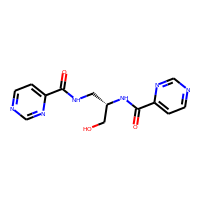
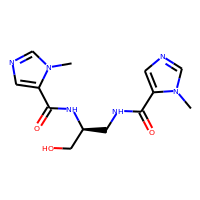
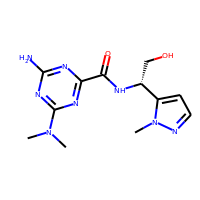
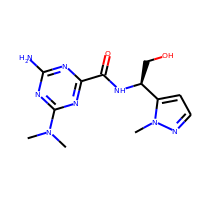
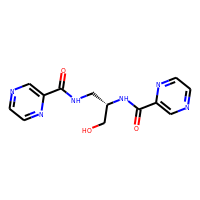

In [18]:
combo_df.head()

Based on what we see above, it looks like many of the hits are similar.  Let's look at a few more molecules. 

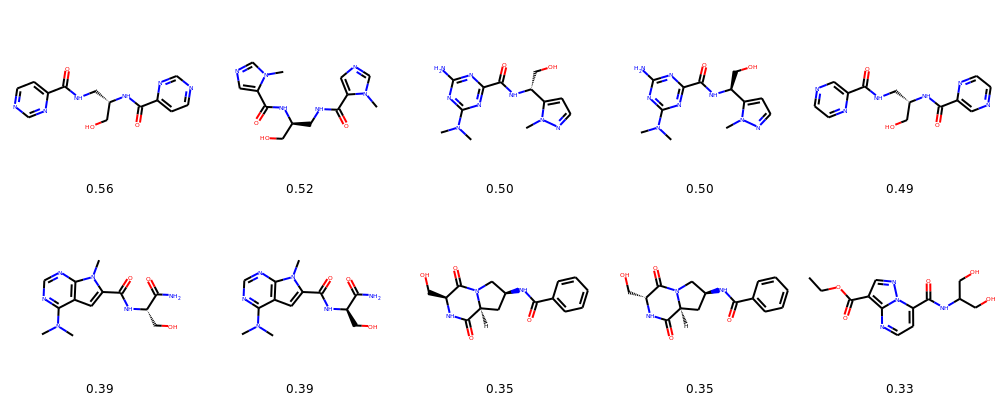

In [39]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])

Indeed many of the molecules are very similar and might end up being redundant in our screen.  One way of being more efficient with our screen would be to cluster the molecules and only screen the highest scoring molecule in each cluster. The RDKit has an implementation of the Butina clustering method, one of the most highly used methods in Cheminformatics. A small amount of code is necessary to cluster a set of molecules.  The only parameter required for Butina clustering is the cluster cutoff.  If the Tanimoto similarity of two molecules is greater than the cutoff, the molecules are put into the same cluster.  If the similarity is less than the cutoff the molecules are put into different clusters. 

In [27]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

Before clustering, we will create a new dataframe with only the top 100 scoring molecules. Since combo_df is already sorted, we only have to use the "head" function to select the first 100 rows in the dataframe. 

In [35]:
best_100_df = combo_df.head(100).copy()

We can then create a new column containing the cluster identifier for each compound.

In [37]:
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
63669,O=C(NC[C@@H](CO)NC(=O)c1ccncn1)c1ccncn1,ZINC000681745616,0,0.438595,0.561404,,55
55121,Cn1cncc1C(=O)NC[C@@H](CO)NC(=O)c1cncn1C,ZINC000644062250,0,0.481628,0.518372,,54
38671,CN(C)c1nc(N)nc(C(=O)N[C@H](CO)c2ccnn2C)n1,ZINC000566403331,0,0.501487,0.498513,,26
38672,CN(C)c1nc(N)nc(C(=O)N[C@@H](CO)c2ccnn2C)n1,ZINC000566403338,0,0.501487,0.498513,,26
63530,O=C(NC[C@@H](CO)NC(=O)c1cnccn1)c1cnccn1,ZINC000680525179,0,0.508548,0.491452,,53

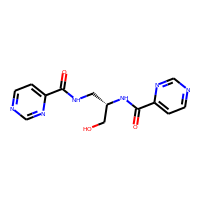
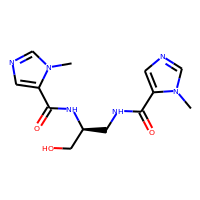
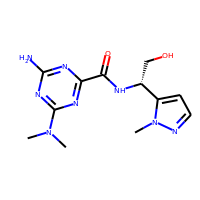
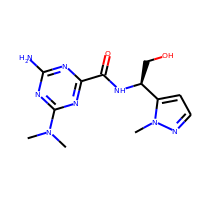
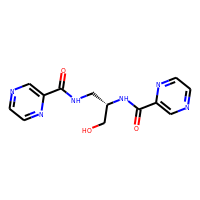

In [38]:
best_100_df.head()

We can use the "unique" function to determine that we have 55 unique clusters.

In [47]:
len(best_100_df.Cluster.unique())

55

Ultimately, we would like to purchase these compounds.  In order to do this, we need need to save a csv file with molecules we plan to purchase.  The "drop_duplicates" function can be used to select one molecule per cluster.  By default, the function starts from the top of the table and removes rows with values that have already been seen. 

In [39]:
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")

In [40]:
best_cluster_rep_df.shape

(55, 7)

In [41]:
best_cluster_rep_df.to_csv("best_cluster_represenatives.csv")